## Heart Disease Prediction using Machine Learning

We will be closely working with a heart disease dataset, and our sole aim is to build a model to detect the probability of person that a patient will have a heart problem or not.

Reference: https://www.analyticsvidhya.com/blog/2022/02/heart-disease-prediction-using-machine-learning/

In [1]:
# import necessary libraries to explore the data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix

# import python scripts we created to help with feature engineering
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.helpers import identify_missing_data, feature_importance_plot

## Read and Explore the Data

In [2]:
# read the data

heart_disease_data = pd.read_csv('../data/heart_attack_data.csv')

# preview the data
heart_disease_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,28,1,2,130.0,132.0,0.0,2.0,185.0,0.0,0.0,NaN,NaN,NaN,0
1,29,1,2,120.0,243.0,0.0,0.0,160.0,0.0,0.0,NaN,NaN,NaN,0
2,29,1,2,140.0,NaN,0.0,0.0,170.0,0.0,0.0,NaN,NaN,NaN,0
3,30,0,1,170.0,237.0,0.0,1.0,170.0,0.0,0.0,NaN,NaN,6.0,0
4,31,0,2,100.0,219.0,0.0,1.0,150.0,0.0,0.0,NaN,NaN,NaN,0


In [3]:
# check the shape of the data

heart_disease_data.shape

# we have 294 rows of data, and 14 potential features.
# small data set

(294, 14)

In [4]:
# check the summary information of the data

heart_disease_data.info()

# do we have any categorical data that needs processing?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  293 non-null    float64
 4   chol      271 non-null    float64
 5   fbs       286 non-null    float64
 6   restecg   293 non-null    float64
 7   thalach   293 non-null    float64
 8   exang     293 non-null    float64
 9   oldpeak   294 non-null    float64
 10  slope     104 non-null    float64
 11  ca        3 non-null      float64
 12  thal      28 non-null     float64
 13  target    294 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 32.3 KB


In [5]:
# check the distribution of the target

heart_disease_data.target.value_counts(dropna = True, normalize = True)

# The data is slightly imbalanced, with roughly 36% of patients having had a heart disease

0    0.639456
1    0.360544
Name: target, dtype: float64

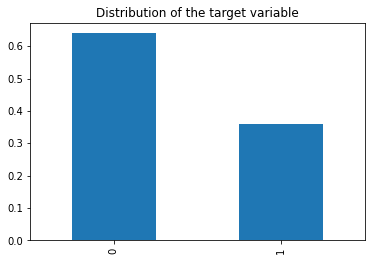

In [6]:
# visualise the distribution of the target

heart_disease_data.target.value_counts(normalize = True).plot(kind = 'bar')
plt.title("Distribution of the target variable");

# This is an example of an imbalanced dataset

In [7]:
# question: check how much missing data do we have

missing_value_df = identify_missing_data(heart_disease_data)
missing_value_df


,feature,percent_missing,data_type
0,ca,98.98,float64
1,thal,90.48,float64
2,slope,64.63,float64
3,chol,7.82,float64
4,fbs,2.72,float64
5,trestbps,0.34,float64
6,restecg,0.34,float64
7,thalach,0.34,float64
8,exang,0.34,float64


In [8]:
print("# of features with missing data:", missing_value_df.shape[0])

# of features with missing data: 9


## Data Cleaning

In [9]:
# drop features which have more than 70% missing values
# I have picked a higher threshold because slope is highly correlated with the target

# option 1
heart_disease_data_cleaned = heart_disease_data.drop(['thal', 'ca'], axis = 1)

In [10]:
# option 2 - identify cols to drop
cols_to_drop = list(missing_value_df[missing_value_df.percent_missing > 70].feature)
print("number of columns to drop:", len(cols_to_drop))
print(cols_to_drop)

heart_disease_data_cleaned = heart_disease_data.drop(cols_to_drop, axis = 1)

number of columns to drop: 2
['ca', 'thal']


In [11]:
# check the columns were dropped

missing_value_df = identify_missing_data(heart_disease_data_cleaned)
missing_value_df

# we have 7 features with missing data left

,feature,percent_missing,data_type
0,slope,64.63,float64
1,chol,7.82,float64
2,fbs,2.72,float64
3,trestbps,0.34,float64
4,restecg,0.34,float64
5,thalach,0.34,float64
6,exang,0.34,float64


In [12]:
# check if the data has any duplicates

heart_disease_data_cleaned[heart_disease_data_cleaned.duplicated(keep=False)]

# this shows two rows that are duplicated

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target
101,49,0,2,110.0,NaN,0.0,0.0,160.0,0.0,0.0,NaN,0
102,49,0,2,110.0,NaN,0.0,0.0,160.0,0.0,0.0,NaN,0


In [13]:
print("# of rows with duplicated data data:", heart_disease_data_cleaned[heart_disease_data_cleaned.duplicated(keep=False)].shape[0])

# of rows with duplicated data data: 2


In [14]:
# going to drop the first appearance of duplicated data

print("shape of data after dropping with the duplicates:", heart_disease_data_cleaned.shape)

heart_disease_data_cleaned = heart_disease_data_cleaned[~heart_disease_data_cleaned.duplicated(keep='first')]

print("shape of data after dropping one of the duplictaes:", heart_disease_data_cleaned.shape)
# we dropped one row of data

shape of data after dropping with the duplicates: (294, 12)
shape of data after dropping one of the duplictaes: (293, 12)


## Feature Engineering

The goal of EDA is to understand the data and identify if we need to do any additional data cleaning or feature engineering. From the EDA from last week, and this week, we know:
- We have 7 numerical features with missing data left.
- All the features have a numerical data type type, so we do not have to do any additonal encoding
- Since we have no highly correlated features (positive or negative), we do not have to drop any features
- From the EDA last week, we identified one feature with low standard deviation. However, this was also dropped during the data cleaning. 


We just need to handle the missing data in this step.

### Handling Missing Data

In [15]:
missing_value_df = identify_missing_data(heart_disease_data_cleaned)
missing_value_df

,feature,percent_missing,data_type
0,slope,64.51,float64
1,chol,7.51,float64
2,fbs,2.73,float64
3,trestbps,0.34,float64
4,restecg,0.34,float64
5,thalach,0.34,float64
6,exang,0.34,float64


In [16]:
# fill the remaining features with missing values with 0

# Option 1
heart_disease_data_cleaned.slope.fillna(0, inplace = True)
heart_disease_data_cleaned.chol.fillna(0, inplace = True)
heart_disease_data_cleaned.fbs.fillna(0, inplace = True)
heart_disease_data_cleaned.trestbps.fillna(0, inplace = True)
heart_disease_data_cleaned.restecg.fillna(0, inplace = True)
heart_disease_data_cleaned.exang.fillna(0, inplace = True)
heart_disease_data_cleaned.thalach.fillna(0, inplace = True)


In [17]:
# Option 2

for f in list(missing_value_df.feature):
    heart_disease_data_cleaned[f].fillna(0, inplace = True)

In [18]:
# check to see if we have any missing values that need handling

missing_value_df = identify_missing_data(heart_disease_data_cleaned)
missing_value_df

,feature,percent_missing,data_type


- We have handled the missing data and since we have no missing data and non numerical data types, we are one step closer to building our ML model.
- We will be using Logistic Regression and Decision Trees to build our first Heart Disease Prediction Model we need to scale the data before building our ML model.

In [19]:
# last thing we need to do before building our ML model is defining the target and features

target = heart_disease_data_cleaned["target"]
features = heart_disease_data_cleaned.drop(["target"], axis = 1)


### Building the ML Model 

#### Logistic Regression Model

In [20]:
# we have to scale the features when training a logistic regression model

scaler = MinMaxScaler()
scaler.fit(features)
# transform training data
features_scaled = scaler.transform(features)


In [21]:
# the shape of the features data frame and the scaled features are the same
print(features.shape)
print(features_scaled.shape)

(293, 11)
(293, 11)


In [22]:
# split the heart disease data into training and test data

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(features_scaled, 
                                                                  target,
                                                                  test_size = 0.2, 
                                                                  random_state = 8888)


In [23]:
# print the shape of the training data

print("Training Data")
print("Shape of X_train", X_train_scaled.shape)
print("Shape of y_train", y_train.shape)

Training Data
Shape of X_train (234, 11)
Shape of y_train (234,)


In [24]:
# print the shape of the test data 

print("Test Data")
print("Shape of X_test", X_test_scaled.shape)
print("Shape of y_test", y_test.shape)

Test Data
Shape of X_test (59, 11)
Shape of y_test (59,)


In [25]:
# import the logistic regression model

clf = LogisticRegression()


In [26]:
# fit the model to the training data

clf.fit(X_train_scaled, y_train)

LogisticRegression()

In [27]:
# use the trained model to make predictions on the test data

y_pred_lr = clf.predict(X_test_scaled)
y_pred_lr

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
print("first five predicted values:", y_pred_lr[0:5])
print("first five actual values:", list(y_test[0:5]))

# can compare the first five predicted and actual values

first five predicted values: [0 1 1 0 0]
first five actual values: [0, 1, 1, 0, 0]


In [29]:
# Evaluating the performance of the model i.e. how well is the model able to make predictions

accuracy_score(y_test, y_pred_lr)


0.7966101694915254

In [30]:
recall_score(y_test, y_pred_lr)


0.631578947368421

In [31]:
precision_score(y_test, y_pred_lr)


0.7058823529411765

In [32]:
f1_score(y_test, y_pred_lr)


0.6666666666666667

In [33]:
print(classification_report(y_test, y_pred_lr))

# this report summarises the evaluation metrics from above. 
# Looks like the model is better at predicting patients without heart disease

              precision    recall  f1-score   support

           0       0.83      0.88      0.85        40
           1       0.71      0.63      0.67        19

    accuracy                           0.80        59
   macro avg       0.77      0.75      0.76        59
weighted avg       0.79      0.80      0.79        59



In [34]:
confusion_matrix(y_test, y_pred_lr)

# the diagonal shows the number of times the model predicted correctly

array([[35,  5],
       [ 7, 12]])

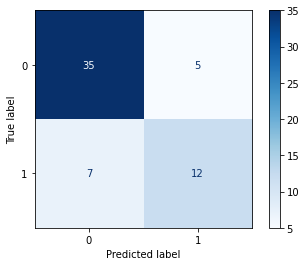

In [35]:
# can also visualise the predictions to see where the model has incorrectly classified the data

plot_confusion_matrix(clf, 
                      X_test_scaled, 
                      y_test,
                      cmap = plt.cm.Blues);

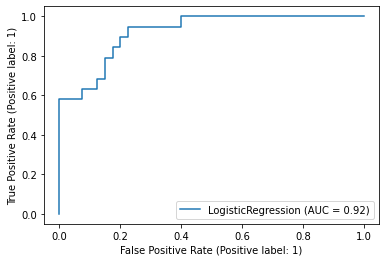

In [36]:
from sklearn.metrics import plot_roc_curve

# handy sklearn function to plot Receiver operating characteristic (ROC) curve, with the area under the curve.
# The TPR (recall) defines how many correct positive results occur among all positive samples available during the test. 
# FPR, on the other hand, defines how many incorrect positive results occur among all negative samples 
# available during the test.

plot_roc_curve(clf,
               X_test_scaled, 
               y_test);                      

# AUC of 0.92; the higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.
# results may appear higher because this data is imbalanced

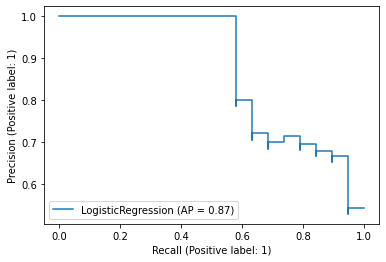

In [37]:
from sklearn.metrics import plot_precision_recall_curve

# Since the data is imbalanced, may want to consider Precision-Recall curve
# precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.
# The precision-recall curve shows the tradeoff between precision and recall for different threshold. 

plot_precision_recall_curve(clf,
                            X_test_scaled,
                            y_test);

# Appears to be some balance between precision and recall

- The Logistic Regression Model is able to predict patients with heart disease and not, but seems to do a better job predicting patients without heart disease. This could also be we trained our model on patients
- This is just the beginning of how we evaluate model performance....
- Question: What do we know about the most important features at this point?

#### Decision Tree

In [38]:
# We do not have to use scaled data, so start by splitting data into train and test sets again

X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target,
                                                test_size = 0.2, 
                                                random_state = 8888)

In [39]:
# print the shape of the training data

print("Training Data")
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)

Training Data
Shape of X_train (234, 11)
Shape of y_train (234,)


In [40]:
# print the shape of the test data 

print("Test Data")
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)

Test Data
Shape of X_test (59, 11)
Shape of y_test (59,)


In [41]:
# Import and Fit the Decision Tree Model

clf_tree = DecisionTreeClassifier()

clf_tree.fit(X_train, y_train)

DecisionTreeClassifier()

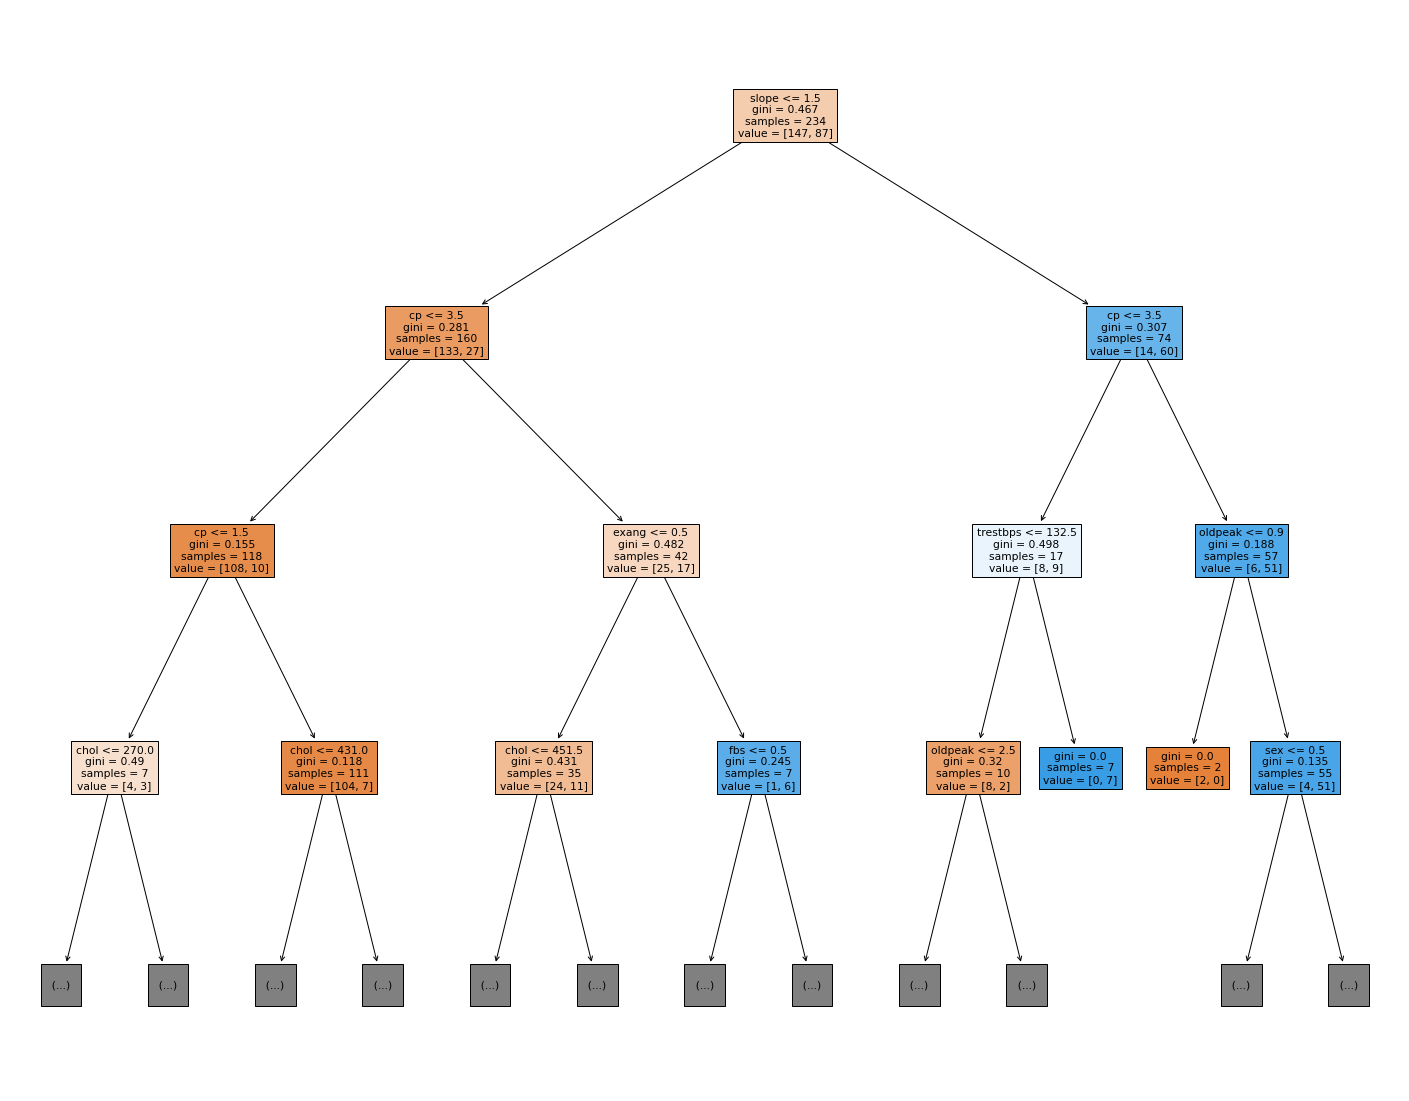

In [42]:
# Just for demo - visualising the decision tree 

from sklearn import tree

fig = plt.figure(figsize=(25 , 20))
_ = tree.plot_tree(clf_tree, 
                   feature_names = list(X_train.columns),  
                   max_depth = 3,
                   filled = True)

# question: what is the root node?

In [43]:
# Make predictions on unseen data

y_pred_dt = clf_tree.predict(X_test) 
y_pred_dt

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [44]:
print("first five predicted values:", y_pred_dt[0:5])
print("first five actual values:", list(y_test[0:5]))


first five predicted values: [0 1 1 0 1]
first five actual values: [0, 1, 1, 0, 0]


In [45]:
print("accuracy:", round(accuracy_score(y_test, y_pred_dt), 2))
print("recall:", round(recall_score(y_test, y_pred_dt), 2))
print("precision:", round(precision_score(y_test, y_pred_dt), 2))
print("f1-score:", round(f1_score(y_test, y_pred_dt), 2))

# Question: How is the model performing compared to the Logistic Regression Model?

accuracy: 0.73
recall: 0.68
precision: 0.57
f1-score: 0.62


In [46]:
# This code is just for demonstration, and to compare the metrics of the models

pd.DataFrame({"Model Name": ['Logistic Regression', 'Decision Tree'],
              "Accuracy": [round(accuracy_score(y_test, y_pred_lr), 2), 
                           round(accuracy_score(y_test, y_pred_dt), 2)],
              "Recall": [round(recall_score(y_test, y_pred_lr), 2), 
                           round(recall_score(y_test, y_pred_dt), 2)],
              "Precision": [round(precision_score(y_test, y_pred_lr), 2), 
                           round(precision_score(y_test, y_pred_dt), 2)],
              "F1-Score": [round(f1_score(y_test, y_pred_lr), 2), 
                           round(f1_score(y_test, y_pred_dt), 2)],
             })

# Question - which Model has a highest accuracy, recall, precision and f1-score?

,Model Name,Accuracy,Recall,Precision,F1-Score
0,Logistic Regression,0.80,0.63,0.71,0.67
1,Decision Tree,0.73,0.68,0.57,0.62


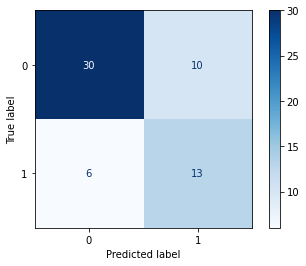

In [47]:
# plot confusion matrix

plot_confusion_matrix(clf_tree, X_test, y_test, cmap = plt.cm.Blues);

In [48]:
# print classification report

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79        40
           1       0.57      0.68      0.62        19

    accuracy                           0.73        59
   macro avg       0.70      0.72      0.70        59
weighted avg       0.75      0.73      0.73        59



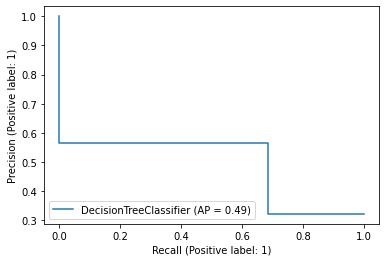

In [49]:
plot_precision_recall_curve(clf_tree,
                            X_test,
                            y_test);

# Can also see a drop in AP

##### Feature Importance

In [50]:
feat_importances = pd.Series(clf_tree.feature_importances_,
                                 index = X_train.columns)

feat_importances

# Question: Are there any features that have no feature importance?
# What would happen if you removed this feature - does it improve model performance?

age         0.033544
sex         0.025795
cp          0.132252
trestbps    0.121193
chol        0.128948
fbs         0.027382
restecg     0.030495
thalach     0.033000
exang       0.040478
oldpeak     0.045261
slope       0.381652
dtype: float64

In [51]:
# features with the lowest importance

feat_importances.nsmallest(5)

sex        0.025795
fbs        0.027382
restecg    0.030495
thalach    0.033000
age        0.033544
dtype: float64

In [52]:
# can use code to identify the most redundant features - lets say less than 0.02

redundant_features = list(feat_importances[feat_importances < 0.02].index)
print(redundant_features)

[]


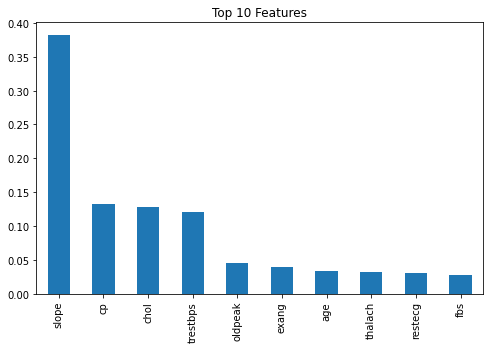

In [53]:
# Plot the feature importance

feature_importance_plot(clf_tree, X_train, n = 10)

- The Logistic Regression Model appears to out perform the Decision Tree in terms of some baseline metrics.
- However, the Decision Tree Algorithm showcases which features the model is selecting when making decisions, and which features are considered "important"

### Challenge yourself (OPTIONAL): Can you improve the recall?

1. Train the Decision Tree on scaled data

2. Remove the Features you identified as redundant and build the Logistic Regression and Decision Tree Models again

3. We know the data is imbalanced - what would happen if we included a 'stratify' parameter in the train test split function?

In [54]:
# Code you will need

# How do the results of the logistic regression and decision tree model change?
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(
                                                features, 
                                                target,
                                                stratify = target,
                                                test_size = 0.2, 
                                                random_state = 8888)